## Bet Against the Beta in HK market

We use regression to find 12 month rolling beta of the stock, based on beta to group and rank quintile,

open long position for stocks that have low beta and open short position for stocks with high beta.

But is that also work in HK market?

How about using beta neutral strategy? Will that decrease risk and improve return?

To calculate the risk free rate, I use 1 month hibor fixing rate data from HKMA API. 

For HK stock price data, I use Yfinance data.

Data range from 2005-01-01 to 2024-06-30.

In [1]:
import pandas as pd
import numpy as np 
import os
import yfinance as yf
import requests
import datetime
import time
import matplotlib.pyplot as plt
import sys
import warnings
warnings.simplefilter('ignore')
from scipy import stats

try:
    data = pd.read_csv("data/hibor.csv")
    data['Date'] = pd.to_datetime(data["end_of_date"])
    data.set_index('Date', inplace=True)
    data = data.drop_duplicates(subset="end_of_date", keep ='last')
    data = data.sort_index()
except:
    start_date = "2005-01-01"
    end_date = "2024-06-30"

    start_date_dt=datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt=datetime.datetime.strptime(end_date, '%Y-%m-%d')

    curr_start_date_dt = start_date_dt
    curr_end_date_dt = curr_start_date_dt + datetime.timedelta(days=120)

    data_list=[]
    while curr_start_date_dt <= end_date_dt:
        if curr_start_date_dt + datetime.timedelta(days=120) > end_date_dt:
            curr_end_date_dt = end_date_dt

        curr_start_date_str = curr_start_date_dt.strftime('%Y-%m-%d')
        curr_end_date_str = curr_end_date_dt.strftime('%Y-%m-%d')

        curr_start_date_dt += datetime.timedelta(days=120)
        curr_end_date_dt += datetime.timedelta(days=120)

        url = "https://api.hkma.gov.hk/public/market-data-and-statistics/daily-monetary-statistics/daily-figures-interbank-liquidity"
        url += "?choose=end_of_date&from=" +curr_start_date_str+ "&to=" +curr_end_date_str

        response = requests.get(url)
        data = response.json()
        data = pd.json_normalize(data['result']['records'])
        data_list.append(data)
        time.sleep(1)
    
    data = pd.concat(data_list)
    data.to_csv("data/hibor.csv")    
    data['Date'] = pd.to_datetime(data["end_of_date"])
    data.set_index('Date', inplace = True)
    data = data.drop_duplicates(subset="end_of_date", keep = 'last')
    data = data.sort_index()
    


In [2]:
tickers = [
    "0001.Hk", "0002.HK", "0003.HK", "0004.HK", "0005.HK", "0006.HK", "0011.HK", "0012.HK", "0014.HK", "0016.HK", "0017.HK", "0019.HK",
    "0023.HK", "0027.HK", "0066.HK", "0101.HK", "0175.HK", "0241.HK", "0267.HK", "0285.HK", "0288.HK", "0291.HK", "0316.HK", "0322.HK",
    "0358.HK", "0384.HK", "0386.HK", "0388.HK", "0522.HK", "0546.HK", "0548.HK", "0552.HK", "0669.HK", "0688.HK", "0700.HK", "0728.HK",
    "0762.HK", "0763.HK", "0777.HK", "0788.HK", "0823.HK", "0836.HK", "0857.HK", "0868.HK", "0883.HK", "0902.HK", "0914.HK", "0939.HK",
    "0941.HK", "0960.HK", "0966.HK", "0968.HK", "0981.HK", "0992.HK", "1024.HK", "1038.HK", "1044.HK", "1088.HK", "1093.HK", "1099.HK",
    "1109.HK", "1113.HK", "1177.HK", "1209.HK", "1211.HK", "1299.HK", "1308.HK", "1313.HK", "1336.HK", "1339.HK", "1378.HK", "1398.HK",
    "1658.HK", "1800.HK", "1810.HK", "1818.HK", "1876.HK", "1928.HK", "1972.HK", "1929.HK", "1997.HK", "2013.HK", "2015.HK", "2018.HK",
    "2020.HK", "2057.HK", "2269.HK", "2313.HK", "2314.HK", "2318.HK", "2319.Hk", "2328.HK", "2331.HK", "2359.HK", "2382.HK", "2388.HK",
    "2600.HK", "2601.HK", "2618.HK", "2628.HK", "2688.HK", "2883.HK", "2899.HK", "3323.HK", "3328.HK", "3690.HK", "3692.HK", "3988.HK",
    "3993.HK", "6618.HK", "6690.HK", "6862.HK", "9618.HK", "9626.HK", "9633.HK", "9666.HK", "9866.HK", "9868.HK", "9888.HK", "9961.HK",
    "9988.HK", "9999.HK"
    ]
def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2024-06-30')

        df.to_csv(file_name)

    df = pd.read_csv(file_name)
    df["Date"] = df["Date"].astype("string")
    df["Date"] = df["Date"].str[:10]
    df['Date'] = pd.to_datetime(df["Date"])
    df.set_index(df["Date"], inplace=True, drop=True)

    df['Risk_free_rate'] = data["hibor_fixing_1m"]
    df = df.resample('M').agg({
        "Open":'first',                       # We will open position at the first day open price every month
        "Close":"last",                       # We will close position at the last day close price every month
        'Risk_free_rate':"last",
        "Date":"last"
        })
    df['this_month_return'] = (df["Close"] - df["Open"]) / df["Open"]
    df["next_month_return"] = df['this_month_return'].shift(-1)
    df['symbol'] = symbol
    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

            
hsi = load_data("^HSI")
tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')

Loaded data for 122 companies


In [3]:
trade = pd.DataFrame()
ngroup = 5                   # We group and rank stocks based on their rolling beta into 5 groups 
for stock in holder:
    stock["market_return"] = hsi['this_month_return']
    stock["rolling_12_month_beta"] = 0
    for a in range(0, len(stock)-12 ):
        res = stats.mstats.linregress(stock["this_month_return"][(a):(a+12)],
                                        stock['market_return'][(a):(a+12)])
        stock["rolling_12_month_beta"][(a+11)] = res[0]
    stock['rolling_12_month_beta'] = stock['rolling_12_month_beta'].fillna(0)
    stock = stock[12:-1]          #drop last row as we don't have next month return for July 2024
    stock=stock.loc[stock["rolling_12_month_beta"] >= 0] #idrop negative beta stocks
    trade=pd.concat([trade,stock])
    
trade=trade.sort_index()

trade["rank"] = 0
trade["rank"] = trade.groupby(trade['Date'])["rolling_12_month_beta"].transform(lambda x: 
                                pd.qcut(x.rank(method='first'), q=ngroup, labels=range(1, ngroup + 1)))


## Without beta neutral strategy:

Each month we rank and divide stocks into quintile groups to long lowest beta stocks (Quintile group 1) and short sell highest beta stocks (Quintile group 5)

<b>Negative beta stocks are not considered.

Sharpe Ratio is : 0.2647540793878648


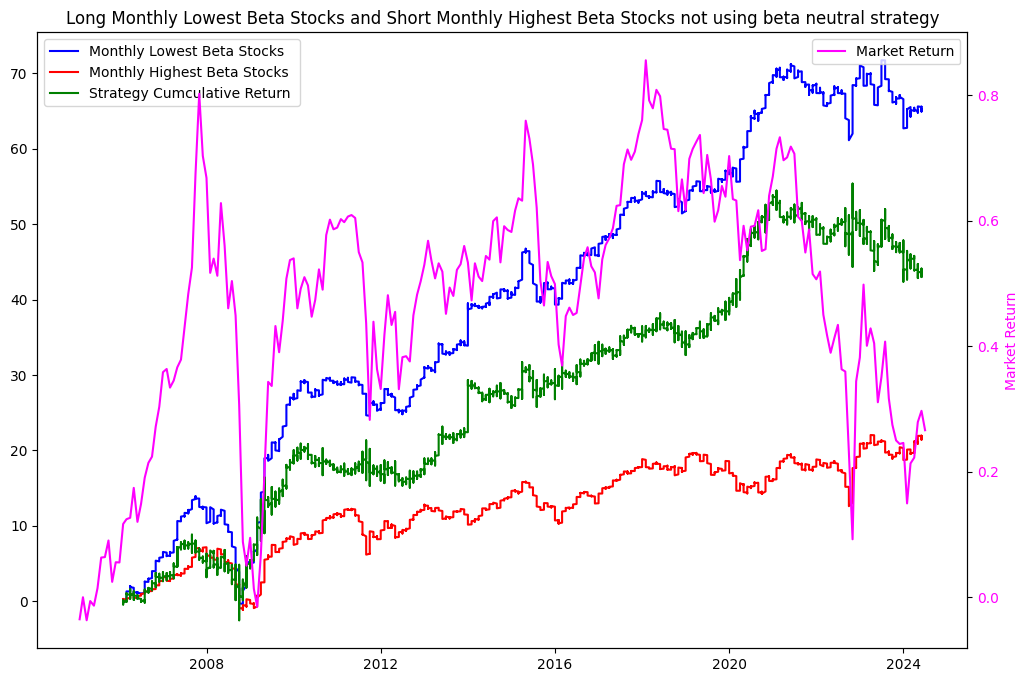

In [4]:
short_position = trade.loc[trade["rank"]==5, "next_month_return"].cumsum()
long_position = trade.loc[trade["rank"]==1, "next_month_return"].cumsum()

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(long_position, label = "Monthly Lowest Beta Stocks", color ="blue")
ax1.plot(short_position, label = "Monthly Highest Beta Stocks", color ="red")
cumculative_return = long_position - short_position
ax1.plot(cumculative_return, label = "Strategy Cumculative Return ", color= "green")
ax1.legend()

ax2 = ax1.twinx()
market_return = hsi["this_month_return"].cumsum()
ax2.plot(market_return,label = "Market Return", color="fuchsia")
ax2.set_ylabel("Market Return",color="fuchsia")
ax2.tick_params(axis='y', labelcolor='fuchsia')
ax2.legend()
plt.title("Long Monthly Lowest Beta Stocks and Short Monthly Highest Beta Stocks not using beta neutral strategy")
risk = pd.concat([trade.loc[trade["rank"]==5, "next_month_return"],
                  trade.loc[trade["rank"]==1, "next_month_return"]]).std()
sharpe = (trade.loc[trade["rank"]==1, "next_month_return"] - trade.loc[trade["rank"]==5, "next_month_return"]).mean() / risk *np.sqrt(12)
print(f"Sharpe Ratio is : {sharpe}")

## Equal Weight Beta Neutral Strategy 

Each month we divide stocks into quintile groups to long lowest beta stocks (Quintile group 1) and short sell highiest beta stocks (Quintile group 5).

But how many shares to long and short each month is based on the beta of each stock. Long lowest beta stocks (Quintile group 1) have positive beta, 

short sell highiest beta stocks (Quintile group 5) result negative beta.

We aim to adjust the amount of shares in long and short to achieve zero beta each month.

In here, we simplify things by multiplying the return of lowest beta stocks. I did not try to restrict only integer amount of shares will be trade.

<b>Negative beta stocks are not considered.


Sharpe Ratio is 0.872005424739978


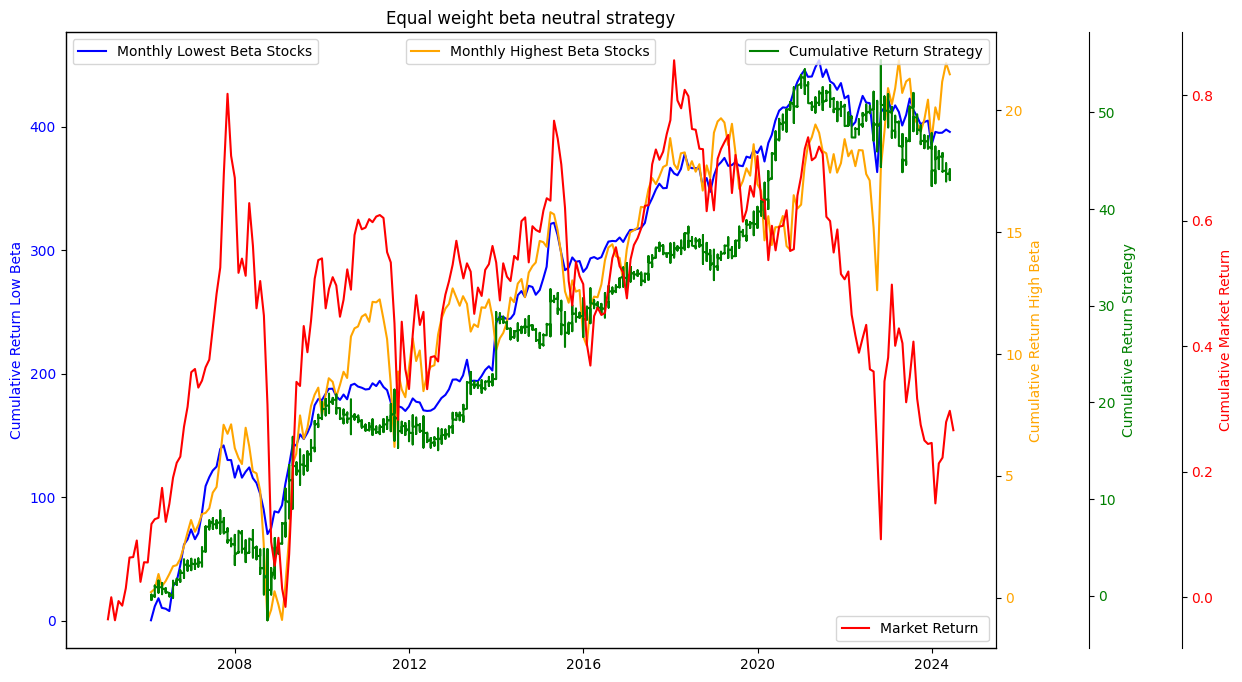

In [5]:
long_positions = pd.DataFrame(trade.loc[trade["rank"]==1])
short_positions = pd.DataFrame(trade.loc[trade["rank"]==5])

total_long_beta = long_positions.groupby(long_positions["Date"])["rolling_12_month_beta"].sum()
total_short_beta = short_positions.groupby(short_positions["Date"])["rolling_12_month_beta"].sum()

multi = total_short_beta / total_long_beta          
total_long_return = long_positions.groupby(long_positions["Date"])["next_month_return"].sum() *multi
total_short_return = short_positions.groupby(short_positions["Date"])["next_month_return"].sum()

cumculative_return_low_beta = total_long_return.cumsum()
cumculative_return_high_beta = total_short_return.cumsum()

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot( cumculative_return_low_beta, label="Monthly Lowest Beta Stocks", color='blue')
ax1.set_ylabel('Cumulative Return Low Beta', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot( cumculative_return_high_beta, label="Monthly Highest Beta Stocks", color='orange')
ax2.set_ylabel('Cumulative Return High Beta', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
ax3.plot( cumculative_return, label="Cumulative Return Strategy", color='green')
ax3.set_ylabel('Cumulative Return Strategy', color='green')
ax3.tick_params(axis='y', labelcolor='green')

ax4=ax1.twinx()
ax4.spines['right'].set_position(('axes', 1.2))
ax4.plot( market_return, label="Market Return ", color='red')
ax4.set_ylabel('Cumulative Market Return', color='red')
ax4.tick_params(axis='y', labelcolor='red')

plt.title("Equal weight beta neutral strategy")
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')
ax4.legend(loc='lower right')

risk = pd.concat([pd.Series(total_long_return), pd.Series(total_short_return)]).std()
sharpe = (pd.Series(total_long_return) - pd.Series(total_short_return)).mean() / risk * np.sqrt(12)
print(f'Sharpe Ratio is {sharpe}')

plt.show()

# Beta weighted strategy in Beta Netural Trading

Now we still long lowest beta quintile stocks and short highest beta quintile stock, but the weighting is based on the value of beta.

For lowest quintile stocks, lower the beta, higher the stock weighting

For highest quintile stocks, higher the beta, higher the stock weighting



In [6]:
long_position_beta_weighted = pd.DataFrame(trade.loc[trade["rank"]==1])
short_positions_beta_weighted = pd.DataFrame(trade.loc[trade["rank"]==5])

# If date in columns, drop it
if "Date" in long_position_beta_weighted.columns:
    long_position_beta_weighted = long_position_beta_weighted.drop(columns="Date")
if "Date" in short_positions_beta_weighted.columns:
    short_positions_beta_weighted = short_positions_beta_weighted.drop(columns="Date")

long_position_betas_df = long_position_beta_weighted.pivot_table(index="Date", columns="symbol", values="rolling_12_month_beta")
short_position_betas_df = short_positions_beta_weighted.pivot_table(index="Date", columns="symbol", values="rolling_12_month_beta")

this_month_return_long = long_position_beta_weighted.pivot_table(index="Date", columns="symbol", values="this_month_return")
this_month_return_short = short_positions_beta_weighted.pivot_table(index="Date", columns="symbol", values="this_month_return")


# Cap the beta 1t 10 and 0.1 to prevent extreme beta from dominating the portfolio
long_position_betas_df = long_position_betas_df.clip(0.1, 10)
short_position_betas_df = short_position_betas_df.clip(0.1, 10)

long_betas_inverse = 1 / long_position_betas_df
short_betas_inverse = 1 / short_position_betas_df


weights_long = long_betas_inverse / (long_betas_inverse.sum() + short_betas_inverse.sum())
weights_short = short_betas_inverse / (long_betas_inverse.sum() + short_betas_inverse.sum())

long_returns = (this_month_return_long * weights_long).sum(axis=1, skipna=True)
short_returns = (this_month_return_short * weights_short).sum(axis=1, skipna=True)

total_returns = long_returns - short_returns

Sharpe Ratio is 0.8419184988134766


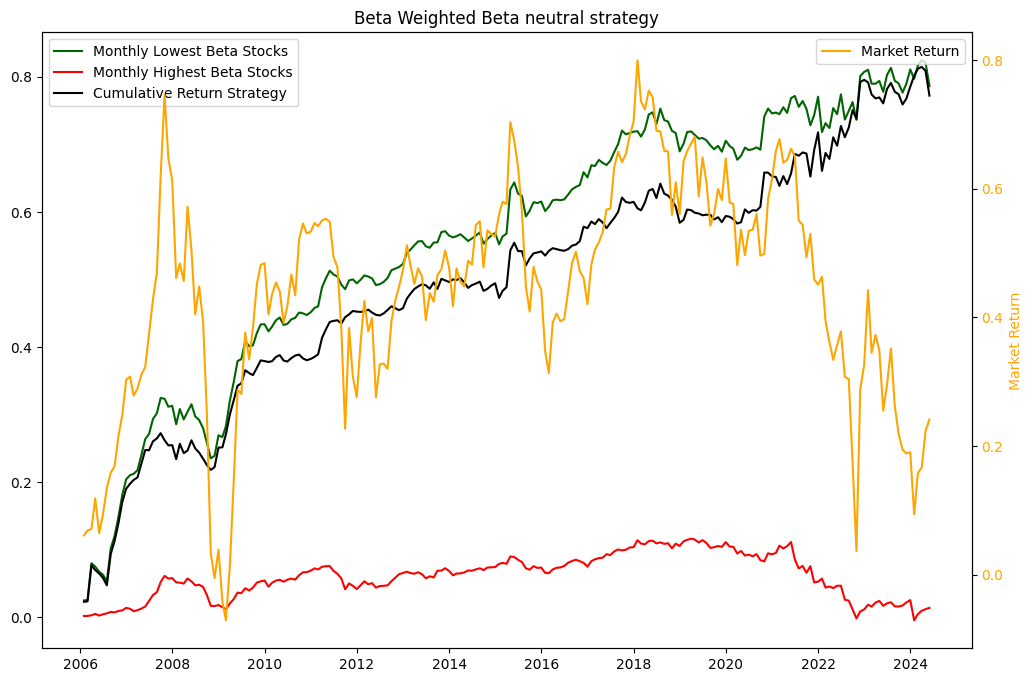

In [7]:
cumculative_return_low_beta = long_returns.cumsum()
cumculative_return_high_beta = short_returns.cumsum()
cumculative_return_strategy = total_returns.cumsum()
market_return = hsi["this_month_return"].loc[total_returns.index].cumsum()
dates = total_returns.index

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(dates, cumculative_return_low_beta, label="Monthly Lowest Beta Stocks",color="darkgreen")
ax1.plot(dates, cumculative_return_high_beta, label="Monthly Highest Beta Stocks",color="red")
ax1.plot(dates, cumculative_return_strategy, label="Cumulative Return Strategy",color="black")

ax2 = ax1.twinx()
ax2.plot(dates, market_return, label="Market Return",color="orange")
ax2.set_ylabel('Market Return', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Beta Weighted Beta Neutral Strategy")
ax1.legend()
ax2.legend()

# Calculating risk and Sharpe ratio
sharpe = total_returns.mean() / total_returns.std() * np.sqrt(12)
print(f'Sharpe Ratio is {sharpe}')
plt.title("Beta Weighted Beta neutral strategy")
plt.show()

## Personal thoughts about the results of the whole Bet Against Beta strategy

The results look good with and without using beta neutral strategy in Hong Kong market. Even though the HSI is just staying in a huge range for many years. However, changing weighting based on the beta of stock within the same quintile will not be helpful. I think the weighting are affected by extreme return thus draging down the strategy return. 

But I think there is a <b>selection bias </b> as:

1. Skipping negative beta stocks, that means I removed most of the stocks that are not following the HK market trend, 
thus most of the stocks left are going up as market go up

2. In HK not much stocks can be short sell, and I have to ensure only stocks with some turnover will be considered. 
Some stocks that are famous and actively trading but recently got suspeneded trading such as Country Garden are ignored.

Besides, due to the beta neutral strategy, I have to <b> buy much more lowest beta stocks from 3 times up to 12 times </b>. In theory the position is beta zero thus not affected by the market, but the <b>risk is multiplied </b>


In Hong Kong, HKEX is still having the <b>lot size requirement for each stock </b>.  In addition, the transaction cost is huge, each trade 0.1% stamp duty plus short sell interest (unfortunately I don't have that data). So it is <b> costly to implement such strategy in HK </b>.

Looking at the performance start from 2021, seems like such strategy may not be working, maybe because when HSI fall, positive beta stocks also follow the market and drop. Negative beta stocks that outperform the market even the HSI drop are ignored.

To sum up, I have proved that Bet Against Beta strategy should also work in HK, but it is costly to implement. More research and backtesting is required, such as split stocks into more groups, consider negative beta stocks, and include more stocks.




